In [40]:
import re
import random
import pandas as pd
import hashlib

In [41]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [42]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Email Auth and Security,532.707628,66.588454,119.581411,8
Debugging in VS Code,1063.600690,96.690972,193.589611,11
Logging in Python,1262.308266,90.164876,239.335859,14
Azure AD Authentication,1334.386820,102.645140,266.128248,13
Azure Private DNS,1342.350622,70.650033,148.837211,19
VMWare,1386.760850,32.250252,65.518436,43
Azure Functions + Visual Studio,1431.296730,110.099748,211.537663,13
C# Basics,1504.995298,48.548235,95.510260,31
RAG Project,1589.884205,99.367763,222.469669,16
Azure Compute Gallery,1954.860787,48.871520,111.733082,40


# Histogram

sum of ages: ~56556.55


<Axes: >

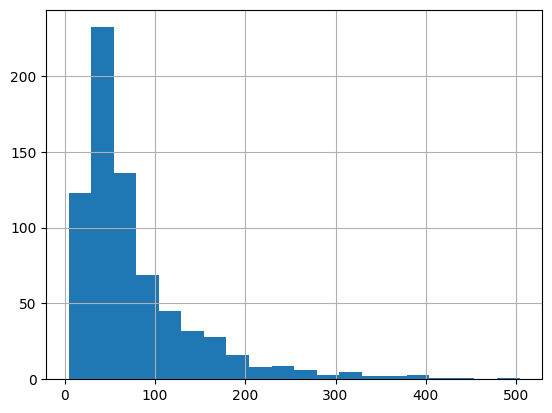

In [43]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [44]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [45]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [46]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [47]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [48]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [49]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [50]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [51]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [52]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 722
Total card age: 56556.55


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
204,Azure Functions + Visual Studio,ASP.NET Web Forms is an older way to build web...,1efe3f4090e2b99b9e4e000a7781aed9,-211.537663,-110.099748,211.537663,1431.296730,0.629468,0,0
205,Azure Functions + Visual Studio,ASP.NET uses a flexible routing system to map ...,dae67573beddd9478be25e780cfee42a,-148.991630,-110.099748,211.537663,1431.296730,0.629468,3,0
206,Azure Functions + Visual Studio,ASP.NET Core provides built-in Dependency Inje...,c576511cc1f41a344509ab4cc7c46d29,-112.354773,-110.099748,211.537663,1431.296730,0.629468,6,0
207,Azure Functions + Visual Studio,ASP.NET supports asynchronous programming with...,6c71bc40773f48dd34ee4486497b9939,-59.600262,-110.099748,211.537663,1431.296730,0.629468,9,0
208,Azure Functions + Visual Studio,An Azure Function is implemented as a static c...,cea43645038d92e845c2c01f3b052299,-33.921925,-110.099748,211.537663,1431.296730,0.629468,12,0
81,JavaScript Concepts,GraphQL: A query language for APIs that allows...,7e7b34d3208558b7ef2938d10bb39b64,-343.976155,-106.945403,343.976155,4919.488541,0.414986,0,0
82,JavaScript Concepts,Lazy Loading: Deferring the loading of non-cri...,b2d7160e58720a8441c71f99cb8fcec5,-277.082765,-106.945403,343.976155,4919.488541,0.414986,3,0
83,JavaScript Concepts,While Loop\nwhile (condition) {\n // Code t...,d2df8fce97a9927ff5941c1db9405753,-203.086508,-106.945403,343.976155,4919.488541,0.414986,6,0
335,JavaScript Concepts,Angular: A comprehensive framework by Google f...,98c8161dd75d5af5639bb6107dc07cc9,-155.516582,-106.945403,343.976155,4919.488541,0.414986,9,0
85,JavaScript Concepts,React Hooks: Functions like useState and useEf...,6567c10a38c31c55b459fac590318cce,-132.219399,-106.945403,343.976155,4919.488541,0.414986,12,0


## Age Max

In [53]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [54]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [55]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [56]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
248,Azure Developer Associate,Where do you associate a stored access policy ...,902bb129e8b619f0bbcf5a9a924c2230,-503.872017,-83.497478,503.872017,6846.793196,0.399460,0,0
157,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-452.794320,-99.785511,452.794320,2095.495738,0.612911,0,0
488,Azure Developer Associate,What are the two primary data types collected ...,f0995a4e3eae52ece78cb2f025efcf7f,-406.731280,-83.497478,503.872017,6846.793196,0.399460,1,1
249,Azure Developer Associate,Which Azure storage service supports a user de...,fd19a76de5cbe2ba07dc309378571330,-401.403936,-83.497478,503.872017,6846.793196,0.399460,2,2
61,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-398.353377,-92.128807,398.353377,5527.728393,0.730431,0,0
489,Azure Developer Associate,What’s the maximum retention you can configure...,d5ee457fbd0609a88312665b94d8621e,-392.526120,-83.497478,503.872017,6846.793196,0.399460,3,0
404,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-374.463528,-99.785511,452.794320,2095.495738,0.612911,1,1
126,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-354.132858,-98.154335,354.132858,3140.938733,0.831237,0,0
312,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-351.872557,-92.128807,398.353377,5527.728393,0.730431,1,1
81,JavaScript Concepts,GraphQL: A query language for APIs that allows...,7e7b34d3208558b7ef2938d10bb39b64,-343.976155,-106.945403,343.976155,4919.488541,0.414986,0,0


In [57]:
existing_cards.head(10).sum()

head                   Azure Functions + Visual StudioAzure Functions...
body                   ASP.NET Web Forms is an older way to build web...
hash                   1efe3f4090e2b99b9e4e000a7781aed9dae67573beddd9...
age                                                         -1678.287662
subject_mean_age                                            -1085.225758
subject_highest_age                                          2777.569088
subject_age_sum                                             31753.926357
head_random_roll                                                5.222274
count                                                                 60
n_fold                                                                 0
dtype: object

In [58]:
existing_cards['age'].mean()

-78.33317285334611